https://www.kaggle.com/code/cdeotte/titanic-using-name-only-0-81818/notebook
- Translated from R to python

# Simple Titanic model using only Name scores 82%!

I'm excited to share my Titanic solution and write my first Kaggle notebook. I've had a fun time building dozens of models. Below is my favorite. This simple model only uses one feature more than the gender model but it scores an impressive 82% and outperforms 97% of all 11,300 Kaggle submissions which are all more complicated! Using only passenger names, gender is deduced from title (Mr. Mrs. etc), children are determined from title (Master.), and family groups are identified by duplicate surnames (last names).  
  
UPDATE: By combining this model with another that classifies single passengers, 85% was achieved [here][1]. Also 83% and 84% were achieved [here][2].

![model](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/tree4.jpeg)

First I'll explain how it works. Then, I'll present my model, code, cross validation, and submission results.

![rules](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/rules2.jpeg)

## Let's begin with the gender model... 
If we just predict females survive and males perish, we cross validate at 78.6% and receive a public leaderboard score of 76.6%.  
 
[1]:https://www.kaggle.com/cdeotte/titanic-wcg-xgboost-0-84688
[2]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210

In [134]:
import polars as pl
import pandas as pd
import numpy as np
from datetime import datetime
import os
import sys
from collections import Counter
import matplotlib.pyplot as plt

sys.path.append(os.path.dirname("/Users/yongjian.tek/Desktop/kaggle/1. Titanic/utils"))
from utils.data import clean_test_to_fit_answer_sheet
pd.set_option('display.max_rows', 999)

In [135]:
train = pd.read_csv('../data/train.csv')
test = clean_test_to_fit_answer_sheet(pl.from_pandas(pd.read_csv('../data/test.csv'))).to_pandas()
answer = pd.read_csv('../data/answer_sheet.csv')[['name', 'age', 'survived']].rename(columns={'name': 'Name', 'age': 'Age', 'survived': 'Survived'})
test = test.merge(answer, on=['Age', 'Name'], how='left')

To improve upon the gender model, we need to determine which males survive and which females perish. By analyzing the Titanic data, we find that many male survivors are among the youth, namely 52.5% = 21/40 of males under 16 years old survive. And most females who perish are among Pclass==3 passengers, namely 50% = 72/144 of Pclass==3 females perish.

In [136]:
# train <- read.csv("../input/titanic/train.csv",stringsAsFactors=F)
# table(train$Survived[train$Sex=='male' & train$Age<16])
# table(train$Survived[train$Sex=='female' & train$Pclass==3])

Counter(train.loc[(train['Sex'] == 'male') & (train['Age'] < 16)]['Survived'])
Counter(train.loc[(train['Sex'] == 'female') & (train['Pclass'] == 3)]['Survived'])

Counter({1: 72, 0: 72})

So let's focus on identifying surviving males and perishing females among these 184 passengers. The data indicates that woman and children were prioritized in rescue. Furthermore it appears that woman and children from the same family survived or perished together. There are 142 females and boys in the training dataset who have a relative (indicated by surname) in the training set that is a female or boy. Let's refer to these 142 passengers as members of "woman-child-groups".

## Let's engineer a new feature to identify "woman-child-groups" and their survival rate.

In [137]:
# # engineer "woman-child-groups" for training dataset
# train$Surname <- substring(train$Name,0,regexpr(",",train$Name)-1)
# train$Surname[train$Title=='man'] <- 'noGroup'
# train$SurnameFreq <- ave(1:891,train$Surname,FUN=length)
# train$Surname[train$SurnameFreq<=1] <- 'noGroup'
# # calculate "woman-child-group" survival rates
# train$SurnameSurvival <- ave(train$Survived,train$Surname)
# table(train$SurnameSurvival[train$Surname!='noGroup'])

train_copy = train.copy()
test_copy = test.copy()

train_copy['Title'] = train_copy['Name'].str.extract(r"(?<=,\s)(\w+)") #(?=\s)
train_copy['Title'] = np.select(
    [train_copy['Title'].isin(["Capt","Don","Major","Col","Rev","Dr","Sir","Mr","Jonkheer"]),
    train_copy['Title'].isin(["Dona","the Countess","Mme","Mlle","Ms","Miss","Lady","Mrs"]),
    train_copy['Title'].isin(["Master"])],
    ['man', 'woman', 'boy'],
    default='woman'
)

train_copy['Surname'] = train_copy['Name'].str.extract(r"(.*)(?=,)")
train_copy['Surname'] = np.where(train_copy['Title'] == 'man', 'noGroup', train_copy['Surname'])
train_copy['SurnameFreq'] = train_copy.groupby(['Surname'])['Surname'].transform('count')
train_copy['Surname'] = np.where(train_copy['SurnameFreq'] <= 1, 'noGroup', train_copy['Surname'])

train_copy['SurnameSurvival'] = train_copy.groupby('Surname')['Survived'].transform('mean')

print(train_copy.shape)
Counter(train_copy.loc[train_copy['Surname'] != 'noGroup']['SurnameSurvival'])
train_copy.groupby(['Surname']).agg({'SurnameSurvival': 'first'});

(891, 16)


In [138]:
# the following "woman-child-groups" all perish
# x=train[train$SurnameSurvival==0,c("Surname")]; unique(x[order(x)])

train_copy.loc[train_copy['SurnameSurvival']==0]['Surname'][:5];

In [139]:
# the following "woman-child-groups" all survive
# x=train[train$SurnameSurvival==1,c("Surname")]; unique(x[order(x)])
train_copy[train_copy['SurnameSurvival']==1]['Surname'][:5];

In [140]:
# the following "woman-child-groups" have mixed survival
# train[train$SurnameSurvival==1/7,c("Surname","Title","Survived")]
# train[train$SurnameSurvival==1/3,c("Surname","Title","Survived")]
# train[train$SurnameSurvival==3/4,c("Surname","Title","Survived")]

train_copy[train_copy['SurnameSurvival'] == 1/7][['Surname', 'Title', 'Survived']];

The above code shows that 124 out of 142 "woman-child-group" passengers were part of "woman-child-groups" that either entirely lived or died. And 18 out of the 142 were part of "woman-child-groups" with mixed survival. Among these 18 passengers, 14 lived or died according to their "woman-child-groups'" average fate and 4 did not. Therefore among all 142 "woman-child-group" passengers,  97.2% = 138/142 lived or died according to their "woman-child-groups'" average fate. Our new engineered feature is a near perfect predictor! Wow!

## Cross validation
Let's try to guess what our cross validation accuracy will be when we use this new engineered feature in addition to the gender model before cross validating.

In [141]:
# library(ggplot2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


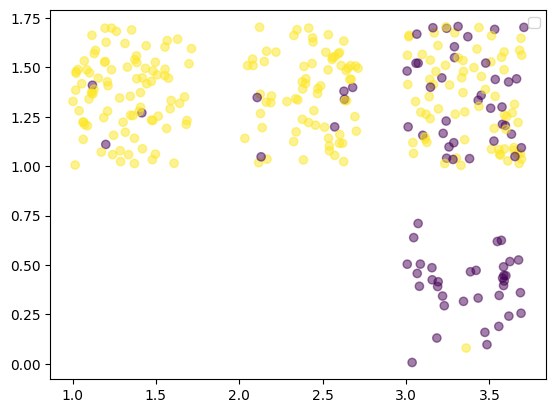

In [142]:
train_copy['AdjustedSurvival'] = (train_copy['SurnameSurvival'] * train_copy['SurnameFreq'] - train_copy['Survived']) / (train_copy['SurnameFreq']-1)

# train_copy['predict'] = 0
train_copy['predict'] = np.select(
    [(train_copy['Title'] == 'woman') & (train_copy['AdjustedSurvival'] == 0),
    train_copy['Title'] == 'woman',
    (train_copy['Title'] == 'boy') & (train_copy['AdjustedSurvival'] == 1)],
    [0, 1, 1], default=0
)

plt.scatter(
    x=train_copy[train_copy['Title'] == 'woman']['Pclass'] + np.random.rand((len(train_copy[train_copy['Title'] == 'woman']['predict'])))/1.4,
    y=train_copy[train_copy['Title'] == 'woman']['predict'] + np.random.rand((len(train_copy[train_copy['Title'] == 'woman']['predict'])))/1.4,
    c=train_copy[train_copy['Title'] == 'woman']['Survived'],
    alpha=0.5
    #s=2
)
plt.legend()

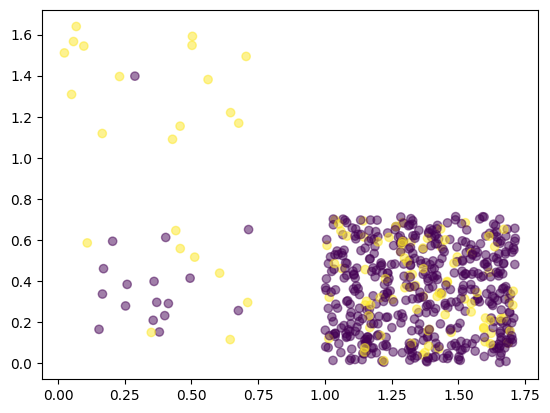

In [143]:
# plot how new predictor changes gender model
# ggplot(train[train$Title!='woman',]) +
#     geom_jitter(aes(x=Title,y=predict,color=factor(Survived))) +
#     labs(title="16 male predictions change from gender model on training set") +
#     labs(x="Title",y="New Predictor") +
#     geom_rect(alpha=0,color="black",aes(xmin=0.5,xmax=1.5,ymin=0.55,ymax=1.45))
# table(train$Survived[train$Title!='woman' & train$predict==1])

plt.scatter(
    x=np.where(train_copy[train_copy['Title'] != 'woman']['Title'] == 'man', 1, 0) + np.random.rand((len(train_copy[train_copy['Title'] != 'woman']['predict'])))/1.4,
    y=train_copy[train_copy['Title'] != 'woman']['predict'] + np.random.rand((len(train_copy[train_copy['Title'] != 'woman']['predict'])))/1.4,
    c=train_copy[train_copy['Title'] != 'woman']['Survived'],
    alpha=0.5
    #s=2
)

The two plots above show that our new predictor changes 52 = 36 + 16 predictions from the gender model when applied to the training set. And amazingly, nearly all of the changes are now correct predictions! Wow! Therefore our cross validation accuracy should be 0.786 + (48/891) =  0.840. Let's test it.

In [144]:
# train_copy['Name'].str.split(',').apply(lambda x: x[0])
# train_copy.head()
# train_copy = train_copy.drop(['SurnameSurvivalTemp', 'Counts'], axis=1)
# train_copy.drop(train_copy.index[0: 10]).shape
# train_copy.iloc[0: 10].shape
# train_copy.head(20)
# np.random.choice([index for index in range(train_copy.shape[0])], train_copy.shape[0], replace=False)
# [x for x in train_copy.drop(train_copy.index[x[first_index:last_index]]).index]
# sorted(x[first_index:last_index])

In [145]:
# Perform 25 trials of 10-fold cross validation
trials = 25
summ = 0
all_accs = []

np.random.seed(123)
for j in range(trials):
    s = 0
    x = np.random.choice([index for index in range(train_copy.shape[0])], train_copy.shape[0], replace=False)
    
    for i in range(10):
        first_index = (i * 89)
        last_index = ((i+1) * 89)

        # print(x[:5])
        # print(x[-5:])

        # Engineer "woman-child-groups" from training subset
        train_copy['Surname'] = train_copy['Name'].str.extract(r"(.*)(?=,)")
        train_copy['Surname'] = np.where(train_copy['Title'] == 'man', 'noGroup', train_copy['Surname'])
        train_copy['SurnameFreq'] = train_copy.groupby(['Surname'])['Surname'].transform('count')
        train_copy['Surname'] = np.where(train_copy['SurnameFreq'] <= 1, 'noGroup', train_copy['Surname'])
        
        # calculate training subset's surname survival rate
        surname_survival_rate = (
            train_copy
            .drop(train_copy.index[x[first_index:last_index]])
            .groupby('Surname', as_index=False)
            .agg(
                SurnameSurvivalTemp = ('Survived', 'mean'),
                Counts = ('PassengerId', 'count'),
                SurvivedSum = ('Survived', 'sum')
            )
            .merge(train_copy[['Surname']].drop_duplicates(), on='Surname', how='outer')
        )
        # print(surname_survival_rate.shape)
        # print(sorted(surname_survival_rate['Surname'].unique()))
        # print(surname_survival_rate['Counts'].sum())
        # display(train_copy.iloc[x[first_index:last_index]][train_copy['Surname'] == 'Allison'])
        # display(surname_survival_rate.head(99))
        
        train_copy = (
            train_copy
            .merge(surname_survival_rate, on='Surname', how='left')
        )

        train_copy['predict'] = np.select(
            [(train_copy['Title'] == 'woman') & (train_copy['SurnameSurvivalTemp'] == 0),
            (train_copy['Title'] == 'boy') & (train_copy['SurnameSurvivalTemp'] == 1),
            train_copy['Title'] == 'woman'],
            [0,1,1], default=0
        )

        c = np.sum(np.abs(train_copy.iloc[x[first_index:last_index]]['Survived'] - train_copy.iloc[x[first_index:last_index]]['predict']))
        s = s + c

        train_copy = train_copy.drop(['SurnameSurvivalTemp', 'Counts', 'SurvivedSum'], axis=1)
        #display(train_copy.head())
    
    accuracy = 1 - s/890
    all_accs.append(accuracy)
    print(f'Trial {j} has 10-fold CV accuracy of {accuracy}')

print(np.mean(all_accs))

Trial 0 has 10-fold CV accuracy of 0.8382022471910112
Trial 1 has 10-fold CV accuracy of 0.8382022471910112
Trial 2 has 10-fold CV accuracy of 0.8382022471910112
Trial 3 has 10-fold CV accuracy of 0.8415730337078652
Trial 4 has 10-fold CV accuracy of 0.8348314606741574
Trial 5 has 10-fold CV accuracy of 0.8325842696629213
Trial 6 has 10-fold CV accuracy of 0.8382022471910112
Trial 7 has 10-fold CV accuracy of 0.8337078651685393
Trial 8 has 10-fold CV accuracy of 0.8314606741573034
Trial 9 has 10-fold CV accuracy of 0.8393258426966292
Trial 10 has 10-fold CV accuracy of 0.8382022471910112
Trial 11 has 10-fold CV accuracy of 0.8382022471910112
Trial 12 has 10-fold CV accuracy of 0.8382022471910112
Trial 13 has 10-fold CV accuracy of 0.8382022471910112
Trial 14 has 10-fold CV accuracy of 0.8393258426966292
Trial 15 has 10-fold CV accuracy of 0.8404494382022472
Trial 16 has 10-fold CV accuracy of 0.8382022471910112
Trial 17 has 10-fold CV accuracy of 0.8359550561797753
Trial 18 has 10-fold

Our cross validation accuracy is 83.6% which is near our guess of 84.0%. 

## Submission to Kaggle and evaluation
Let's try to guess what our Kaggle leaderboard score will be using this new engineered feature in addition to the gender model before submission.

In [146]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,None,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,None,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,None,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,None,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,None,S,1


In [147]:
train_copy = train.copy()
test_copy = test.copy()

train_copy['Title'] = train_copy['Name'].str.extract(r"(?<=,\s)(\w+)") #(?=\s)
train_copy['Title'] = np.select(
    [train_copy['Title'].isin(["Capt","Don","Major","Col","Rev","Dr","Sir","Mr","Jonkheer"]),
    train_copy['Title'].isin(["Dona","the Countess","Mme","Mlle","Ms","Miss","Lady","Mrs"]),
    train_copy['Title'].isin(["Master"])],
    ['man', 'woman', 'boy'],
    default='woman'
)
test_copy['Title'] = test_copy['Name'].str.extract(r"(?<=,\s)(\w+)") #(?=\s)
test_copy['Title'] = np.select(
    [test_copy['Title'].isin(["Capt","Don","Major","Col","Rev","Dr","Sir","Mr","Jonkheer"]),
    test_copy['Title'].isin(["Dona","the Countess","Mme","Mlle","Ms","Miss","Lady","Mrs"]),
    test_copy['Title'].isin(["Master"])],
    ['man', 'woman', 'boy'],
    default='woman'
)

all_data = pd.concat([train_copy, test_copy], axis=0)
all_data['Surname'] = all_data['Name'].str.extract(r"(.*)(?=,)")
all_data['Surname'] = np.where(all_data['Title'] == 'man', 'noGroup', all_data['Surname'])

surname_frequencies = (
    all_data
    .iloc[:891]
    .groupby('Surname', as_index=False)
    .agg(SurnameFreq = ('Surname', 'count'))
)

all_data = (
    all_data
    .merge(surname_frequencies, on='Surname', how='left')
    .assign(Surname = lambda df: df.apply(lambda row: row['Surname'] if row['SurnameFreq'] > 1 else 'noGroup', axis=1))
    #.query('''Surname != 'noGroup' ''')
)

first_surname_by_ticket = (
    all_data
    .iloc[:891]
    .groupby('Ticket', as_index=False)
    .agg(ImputedSurname = ('Surname', 'first'))
)

all_data = (
    all_data
    .merge(first_surname_by_ticket, on='Ticket', how='left')
    .assign(
        Surname = lambda df: df.apply(lambda row: row['ImputedSurname'] if ((row['Title'] != 'man') & (row['Surname'] == 'noGroup')) else row["Surname"], axis=1)
    )
    .assign(
        Surname = lambda df: df.apply(lambda row: 'noGroup' if pd.isna(row['Surname']) else row['Surname'], axis=1)
    )
    .drop('ImputedSurname', axis=1)
)

surname_survival = (
    all_data
    .iloc[:891]
    .groupby('Surname', as_index=False)
    .agg(SurnameSurvival = ('Survived', 'mean'))
)

all_data = (
    all_data
    .merge(surname_survival, on='Surname', how='left')
)

all_data['predict'] = np.select(
    [((all_data['Title'] == 'woman') & (all_data['SurnameSurvival'] == 0)),
    (all_data['Title'] == 'boy') & (all_data['SurnameSurvival'] == 1),
    (all_data['Title'] == 'woman')],
    [0, 1, 1], default=0
)

In [148]:
(all_data.iloc[891:].query('Survived == predict')).shape[0] / all_data.iloc[891:].shape[0]

0.7822966507177034

The plot above shows that our new predictor changes 18 = 10 + 8 predictions from the gender model when applied to the test set. We suspect that all 18 of these chages are correct because nearly all the changes that our predictor made to the training dataset's gender model were correct. Therefore, we would expect that our Kaggle public leaderboard score will be 0.766 + (18/418) =  0.809.

In [91]:
# # create CSV file to submit
# submit <- data.frame(PassengerId = allData$PassengerId[892:1309], Survived = allData$predict[892:1309])
# write.csv(submit,"genderSurnameModel.csv",row.names=F)

![result](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/surnameModel.png)

Wow awesome! Our Kaggle public leaderboard score result is 82.3% which is better than our guess of 80.9%. Luck was in our favor! The test dataset contains 418 observations. The public leaderboard only scores 209 of them. Remember that we changed 18 predictions from the gender model and suspect that all those changes are correct. The gender model receives a score of 0.766 = 160/209, therefore it appears that 12 of our 18 changes were included in our public leaderboard score, (160+12)/209 = 0.823. (Note that only using "Name" to engineer surname groups scores 0.818. Additionally correcting surname groups with "Ticket" scores 0.823.)

## Reflection

How much more predictive information is hiding in the training dataset besides gender and family association? Based on comparison to other submitted models, it seems not much. Since November 2012,  11300 teams have scrutinized the Titanic dataset and searched for predictive features but only 2% of those models outperform this simple gender surname model. Therefore it seems that gender and family association capture most of the prediction power of the training dataset.

I would love to discover ways to improve this model. I welcome everyone to fork this kernel and try to improve its predictive accuracy. Currently it only makes 18 wise predictions and then uses the gender model. Therefore if you can build a model that can predict the other 400 remaining passengers better than the gender model, you will have a Titanic solution scoring over 82%! [More info here][1]. Good luck and have fun!  

![model](https://raw.githubusercontent.com/cdeotte/Kaggle_Images/main/2020/tree3.jpeg)  
  
[1]:https://www.kaggle.com/c/titanic/discussion/57447

In [ ]:
leader = read.csv("../input/kaggle-titanic-leaderboard-may-15-2018/leaderboard.csv")
c1 = "gray30"; c2 = "black"
colors <- c(rep(c1,6),c2,rep(c1,28),c2,rep(c1,11),c2,rep(c1,16))
ggplot(data=leader[leader$Score>=0.6 & leader$Score<=0.9,]) +
    geom_histogram (aes(x=Score),binwidth=1/209,fill=colors,na.rm=TRUE) +
    xlim(c(0.6,0.9)) + ylim(c(0,1500)) +
    labs(title='Histogram of Kaggle titanic public leaderboard scores, May 15 2018') +
    annotate('text', x=0.65, y=300, label='0.627 - All dead model') +
    annotate('text', x=0.662, y=240, label='(=131/209) top 96%') +
    annotate('text', x=0.79, y=1450, label='0.766 - Gender model') +
    annotate('text', x=0.805, y=1390, label='(=160/209) top 64%') +
    annotate('text', x=0.86, y=300, label='0.823 - Surname model') +
    annotate('text', x=0.86, y=240, label='(=172/209) top 2%')

Thank you everyone for reading my first notebook. I enjoyed writing it and look forward to your comments.  

UPDATE: By combining this model with another that classifies single passengers, 85% was achieved [here][13]. Also 83% and 84% were achieved [here][14].

## References
* [Trevor Stephens][1]: Great tutorial for learning both R and Titanic modeling.
* [Itai Blitzer][2]: Titanic code providing hints for engineered features.
* [Megan Risdal][3]: Kaggle’s Titanic tutorial with great ggplot R visualizations.
* [Jason][4]: Kaggle’s Titanic tutorial with great ggplot R visualizations.
* [Michael Hahsler][5]: Shows R syntax for applying different machine learning models.
* [Chris Deotte][6]: Interactive visualizations showing different machine learning models.
* [Chris Deotte][7]: Interactive visualization showing neural network model.
* [Oscar Takeshita][8]: Provides Titanic benchmarks of possible scores
* [bhb2572][9]: Are Titanic models scoring 80% or better luck or science?
* [Cathy O'Neil & Rachel Schutt][10]: Doing Data Science
* [James, Witten, Hastie, & Tibshirani][11]: An Introduction to Statisical Learning
* [Aurelien Geron][12]: Hands-On Machine Learning with Scikit-Learn & TensorFlow

[1]:http://trevorstephens.com/kaggle-titanic-tutorial/getting-started-with-r/
[2]:https://www.kaggle.com/itaibl/kaggle-titanic-tutorial-passing-82-part-1/code
[3]:https://www.kaggle.com/mrisdal/exploring-survival-on-the-titanic
[4]:https://www.kaggle.com/jasonm/large-families-not-good-for-survival
[5]:http://michael.hahsler.net/SMU/EMIS7332/R/viz_classifier.html
[6]:http://www.ccom.ucsd.edu/~cdeotte/programs/classify.html
[7]:http://www.ccom.ucsd.edu/~cdeotte/programs/neuralnetwork.html
[8]:https://www.kaggle.com/pliptor/how-am-i-doing-with-my-score/
[9]:https://www.kaggle.com/c/titanic/discussion/56254
[10]:https://www.amazon.com/Doing-Data-Science-Straight-Frontline/dp/1449358659
[11]:https://www.amazon.com/Introduction-Statistical-Learning-Applications-Statistics/dp/1461471370/
[12]:https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291/
[13]:https://www.kaggle.com/cdeotte/titanic-wcg-xgboost-0-84688
[14]:https://www.kaggle.com/cdeotte/titantic-mega-model-0-84210